# Create and run a RAG model pipeline from scratch.

## What does RAG stand for?

Stands for Retrieval Augmented Generation.

Essentially takes info and passes it to LLM, then LLM generates output based on that information.

* Retrieval - Find info given a certain question, in this example with a PDF discussing nutrition, "What are micronutrients, and what do they do?". The LLM retrieves text related to micronutrients from the textbook.  
* Augmented - Take relevant info and augment are input (The prompt we are giving) to an LLM with that info.
* Generation - Takes first two steps, passes to an LLM for generative outputs. 


## What is the usage of Retrieval Augmented Generation?

RAG improves generation output of LLM.

1. Prevents hallucinations - LLMs are given information factually - they're less likely to hallucinate when they are given actual info as opposed to making up their own information.
2.  Allows LLM to work with custom data - Since LLMs are already trained with internet scaled data, they have a decent understanding of language in general but because of this their responses can be fairly generic. RAG essentially helps create specific responses based on input documents (i.e. your own companies customer support docs, etc.)




## How can RAG be used?

* Customer support chat - Have an existing LLM supported by documentation from the respective company. Retrieves documents already created on how to do certain things, have the LLM use that data when answering. Essentially chatbot for given documentation.
* Email chain analysis - If you're a company with a lost of emails of customer chains, could use a RAG by feeding all of these emails into an LLM, then using said LLM to process that info into more structured data for you to parse through. Maybe turn to JSON.
* Company internal documentation chat
* Textbook Q&A

Essentially: Take relevent documents to a query, and process with an LLM.

Could think of LLM as a calculator for words in this instance.


## Why run locally?

1. No API calls - Potentially faster speed since you're not calling some other LLM.
2. Privacy - Perhaps you're using internal documents you don't want to feed somewhere.
3. Cost - No pricing for API calls.

## Build goals: 

Build RAG pipeline that runs locally on my device. It will do the following:

1. Open up a document I pass it, whether it be a PDF, .MD file, etc.
2. Format the text for an embedding model.
3. Embed all the neccesary chunks of text and turn it into a numerical representation which can be stored.
4. Build a retrieval system (vector search?) to find relevant chunks of text based on the query.
5. Generate a prompt that incorporates the retrieved pieces of text.
6. Generate an answer to the query based on the passage of the document with an LLM.

1. Steps 1-3: Document preprocessing and embedding creation.
2. Step 4-6: Search and answer.

### 1. Document/Text processing and embedding creation

Neccesary:
* PDF document of choice (Not neccesarily PDF - could be Markdown, .txt, etc.)
* Embedding model of choice.

Steps:
1. Import document.
2. Proces text for embedding (split into chunks of sentences).
3. Embed text chunks with embedding model.
4. Save embeddings to file for later use. (Will store on file for many years, however long you need.) 

### Import PDF document


In [2]:
import os
import requests

# Grab PDF path
pdf_path = "human-nutrition-text.pdf"

# Download PDF
if not os.path.exists(pdf_path):
    print("[INFO] File doesn't exist, downloading...")

    # Enter URL of the PDF
    url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"

    # Local filename to save the file we just downloaded.

    filename = pdf_path

    # Send a GET request to the URL. 
    response = requests.get(url)

    # See if request was successful 
    if response.status_code == 200:
        # Open file and save it.
        with open(filename, "wb") as file:
            file.write(response.content)
        print(f"[INFO] The file has been downloaded and saved as {filename}")
    else:
        print(f"[INFO] Failed to download the file. Status code: {response.status_code}")

else:
    print(f"File {pdf_path} already exists.")

    

File human-nutrition-text.pdf already exists.


We now have the PDF! So we can open it.

In [3]:
import fitz
from tqdm.auto import tqdm

def text_formatter(text: str) -> str:
    """Performs minor formatting on text."""
    cleaned_text = text.replace("\n", " ").strip()

    # Potentially more text formatting functions if you need them can go here.

    return cleaned_text

def open_and_read_pdf(pdf_path: str) -> list[dict]:
    doc = fitz.open(pdf_path)
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc)):
        text = page.get_text()
        text = text_formatter(text=text)
        pages_and_texts.append({"page_number": page_number - 41,
                               "page_char_count": len(text), 
                               "page_word_count": len(text.split(" ")),
                               "page_sentence_count_raw": len(text.split(". ")),
                               "page_token_count": len(text) / 4, # 1 token = ~4 characters.
                               "text": text})
    return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)
pages_and_texts[:2]
                               

0it [00:00, ?it/s]

[{'page_number': -41,
  'page_char_count': 29,
  'page_word_count': 4,
  'page_sentence_count_raw': 1,
  'page_token_count': 7.25,
  'text': 'Human Nutrition: 2020 Edition'},
 {'page_number': -40,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count_raw': 1,
  'page_token_count': 0.0,
  'text': ''}]

In [4]:
import random

random.sample(pages_and_texts, k=3)

[{'page_number': 917,
  'page_char_count': 1568,
  'page_word_count': 263,
  'page_sentence_count_raw': 12,
  'page_token_count': 392.0,
  'text': 'Menopause  In the middle-aged years, women undergo a specific change that  has a major effect on their health. They begin the process of  menopause, typically in their late forties or early fifties. The ovaries  slowly cease to produce estrogen and progesterone, which results  in the end of menstruation. Menopausal symptoms can vary, but  often include hot flashes, night sweats, and mood changes. The  hormonal changes that occur during menopause can lead to a  number of physiological changes as well, including alterations in  body composition, such as weight gain in the abdominal area. Bone  loss is another common condition related to menopause due to  the loss of female reproductive hormones. Bone thinning increases  the risk of fractures, which can affect mobility and the ability to  complete everyday tasks, such as cooking, bathing, and 

In [5]:
import pandas as pd

df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-41,29,4,1,7.25,Human Nutrition: 2020 Edition
1,-40,0,1,1,0.00,
2,-39,320,54,1,80.00,Human Nutrition: 2020 Edition UNIVERSITY OF ...
3,-38,212,32,1,53.00,Human Nutrition: 2020 Edition by University of...
4,-37,797,147,3,199.25,Contents Preface University of Hawai‘i at Mā...


In [6]:
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,199.50,10.52,287.00
std,348.86,560.38,95.83,6.55,140.10
min,-41.00,0.00,1.00,1.00,0.00
25%,260.75,762.00,134.00,5.00,190.50
50%,562.50,1231.50,216.00,10.00,307.88
75%,864.25,1603.50,272.00,15.00,400.88
max,1166.00,2308.00,430.00,39.00,577.00


### Further Text processing (Split pages into certain amount of sentences)

Two ways to do this:
1. Can do this by splitting on `". "`.
2. We can do this with a NLP library such as spaCy and nltk. 

In [7]:
from spacy.lang.en import English

# Create an instance of English.

nlp = English()

# Add a sentencizer pipeline
nlp.add_pipe("sentencizer")

# Create a document instance. 
doc = nlp("This is a sentence. This is a second sentence. Even a third sentence.")
assert len(list(doc.sents)) == 3

# Print the sentences.
list(doc.sents)

[This is a sentence., This is a second sentence., Even a third sentence.]

In [8]:
pages_and_texts[0]

{'page_number': -41,
 'page_char_count': 29,
 'page_word_count': 4,
 'page_sentence_count_raw': 1,
 'page_token_count': 7.25,
 'text': 'Human Nutrition: 2020 Edition'}

In [9]:
for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)

    # Make sure all of our sentences are strings.
    # Default is spaCy datatype.)
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]

    # Count the sentences.
    item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [10]:
random.sample(pages_and_texts, k=1)

[{'page_number': 829,
  'page_char_count': 1512,
  'page_word_count': 266,
  'page_sentence_count_raw': 14,
  'page_token_count': 378.0,
  'text': '(which is the reverse of cow’s milk). Whey is much easier for infants  to digest than casein. Casein and whey make a complete protein  with all of the essential amino acids. Another protein in breastmilk,  lactoferrin is an iron-binding protein  that helps keep iron away  from pathogenic bacteria and facilitates the absorption of iron into  an infant’s bloodstream.  For most vitamins and minerals, breast milk provides adequate  amounts for growth and maintenance of optimal health. Although  the absolute amounts of some micronutrients are low, they are  more efficiently absorbed by infants from breast milk. Other  essential components include digestive enzymes that help a baby  digest the breast milk. Human milk also provides the hormones and  growth factors that help a newborn to develop.  Diet and Milk Quality  A mother’s health habits can

In [11]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,199.50,10.52,287.00,10.32
std,348.86,560.38,95.83,6.55,140.10,6.30
min,-41.00,0.00,1.00,1.00,0.00,0.00
25%,260.75,762.00,134.00,5.00,190.50,5.00
50%,562.50,1231.50,216.00,10.00,307.88,10.00
75%,864.25,1603.50,272.00,15.00,400.88,15.00
max,1166.00,2308.00,430.00,39.00,577.00,28.00


### Time to chunk our sentences together.

Essentially want to split large pieces of text into smaller ones. It's referred to as chunking or text splitting.

There is no 'correct' way to do this.

To keep it simple, splitting into groups of 10 sentences. However, could try any other, like 5, or 7, etc.

There's frameworks for doing this, but for this purpose, we are using just base Python.

But why is this done?
1. Text are easier to filter. (smaller groups of texts are more easily inspected than larger groups of texts.)
2. Text chunks are able to fit into our embedding model context window. Roughly 384 tokens as a limit depending on embedding model.
3. Contexts passed to an LLM can be more specific and focused.

In [12]:
# Define split size to turn groups of sentences into chunks.
num_sentence_chunk_size = 10

# Create a function to split list of texts recursively into chunk size.

#e.g. list of 20 -> 2 lists of 10. [10, 10] or [25] -> [10, 10, 5]

# Returns list of lists of strings.
def split_list(input_list: list,
               slice_size: int=num_sentence_chunk_size) -> list[list[str]]:
    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]

test_list = list(range(25))
split_list(test_list)


[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24]]

In [13]:
# Loop through pages and texts and split sentences into chunks.
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"],
                                         slice_size=num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [14]:
random.sample(pages_and_texts, k=1)


[{'page_number': 540,
  'page_char_count': 1420,
  'page_word_count': 233,
  'page_sentence_count_raw': 12,
  'page_token_count': 355.0,
  'text': 'However, scientists do believe vitamin E in combination with other  antioxidants such as zinc and copper may slow the progression of  macular degeneration in people with early-stage disease.  Dementia  The brain’s high glucose consumption makes it more vulnerable  than other organs to oxidative stress. Oxidative stress has been  implicated as a major contributing factor to dementia and  Alzheimer’s disease. Some studies suggest vitamin E supplements  delay the progression of Alzheimer’s disease and cognitive decline,  but again, not all of the studies confirm the relationship. A recent  study with over five thousand participants published in the July 2010  issue of the Archives of Neurology demonstrated that people with  the highest intakes of dietary vitamin E were 25 percent less likely  to develop dementia than those with the lowest inta

In [15]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,199.50,10.52,287.00,10.32,1.53
std,348.86,560.38,95.83,6.55,140.10,6.30,0.64
min,-41.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,260.75,762.00,134.00,5.00,190.50,5.00,1.00
50%,562.50,1231.50,216.00,10.00,307.88,10.00,1.00
75%,864.25,1603.50,272.00,15.00,400.88,15.00,2.00
max,1166.00,2308.00,430.00,39.00,577.00,28.00,3.00


### Splitting each chunk into its own item

Want to embed each chunk of sentences into their own numerical representation.

Gives us good level of granularity.

Can dive specifically into the text sample that was used in model.

In [16]:
import re

# Split each chunk into its own item.

pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]

        # Join them back into paragraph-like structures, so rejoin the list of sentences that were previously broken up.

        joined_sentence_chunk = "".join(sentence_chunk).replace(" ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'.\1', joined_sentence_chunk) # Goes from ".A" -> ". A"

        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # Get some stats on our chunks

        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 #Rough estimation. 1 token = ~4 chars.

        pages_and_chunks.append(chunk_dict)

len(pages_and_chunks)

  0%|          | 0/1208 [00:00<?, ?it/s]

1843

In [17]:
random.sample(pages_and_chunks, k=1)

[{'page_number': 320,
  'sentence_chunk': 'In the stomach, gastric lipase starts to break down triglycerides  into diglycerides and fatty acids.Within two to four hours after  eating a meal, roughly 30 percent of the triglycerides are converted  to diglycerides and fatty acids.The stomach’s churning and  contractions help to disperse the fat molecules, while the  diglycerides derived in this process act as further emulsifiers. However, even amid all of this activity, very little fat digestion occurs  in the stomach. Going to the Bloodstream  As stomach contents enter the small intestine, the digestive system  sets out to manage a small hurdle, namely, to combine the separated  fats with its own watery fluids.The solution to this hurdle is bile. Bile contains bile salts, lecithin, and substances derived from  320  |  Digestion and Absorption of Lipids',
  'chunk_char_count': 819,
  'chunk_word_count': 138,
  'chunk_token_count': 204.75}]

In [18]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1843.00,1843.00,1843.00,1843.00
mean,583.38,746.35,125.00,186.59
std,347.79,453.77,78.23,113.44
min,-41.00,14.00,4.00,3.50
25%,280.50,318.50,50.50,79.62
50%,586.00,760.00,128.00,190.00
75%,890.00,1130.50,190.00,282.62
max,1166.00,1863.00,412.00,465.75


### Filter chunks of text for short chunks.

They may not contain much useful info since they're so short.

In [19]:
# Show random chunks with <30 tokens in len.
min_token_length = 30
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 16.5 | Text: Accessed January 20, 2018. 1032  |  The Effect of New Technologies
Chunk token count: 21.0 | Text: Honor your health – gentle nutrition        Calories In Versus Calories Out  |  1075
Chunk token count: 11.75 | Text: Carbohydrates and Personal Diet Choices  |  275
Chunk token count: 20.5 | Text: PART XVIII  CHAPTER 18. NUTRITIONAL ISSUES  Chapter 18.Nutritional Issues  |  1041
Chunk token count: 24.0 | Text: view it online here:  http://pressbooks.oer.hawaii.edu/ humannutrition2/?p=301  The Atom  |  471


In [20]:
# Filter out dataframe for rows with < 30 tokens.
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -39,
  'sentence_chunk': 'Human Nutrition: 2020  Edition  UNIVERSITY OF HAWAI‘I AT MĀNOA  FOOD SCIENCE AND HUMAN  NUTRITION PROGRAM  ALAN TITCHENAL, SKYLAR HARA,  NOEMI ARCEO CAACBAY, WILLIAM  MEINKE-LAU, YA-YUN YANG, MARIE  KAINOA FIALKOWSKI REVILLA,  JENNIFER DRAPER, GEMADY  LANGFELDER, CHERYL GIBBY, CHYNA  NICOLE CHUN, AND ALLISON  CALABRESE',
  'chunk_char_count': 320,
  'chunk_word_count': 54,
  'chunk_token_count': 80.0},
 {'page_number': -38,
  'sentence_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and  Human Nutrition Program is licensed under a Creative Commons Attribution 4.0  International License, except where otherwise noted.',
  'chunk_char_count': 212,
  'chunk_word_count': 32,
  'chunk_token_count': 53.0}]

In [21]:
random.sample(pages_and_chunks_over_min_token_len, k=1)

[{'page_number': 788,
  'sentence_chunk': 'oranges.Additionally, since 1998, food manufacturers  have been required to add folate to cereals and other  grain products.2  Weight Gain during Pregnancy  During pregnancy, a mother’s body changes in many ways.One  of the most notable and significant changes is weight gain.If a  pregnant woman does not gain enough weight, her unborn baby  will be at risk.Poor weight gain, especially in the second and third  trimesters, could result not only in low birth weight, but also infant  mortality and intellectual disabilities.Therefore, it is vital for a  pregnant woman to maintain a healthy amount of weight gain.Her  weight prior to pregnancy also has a major effect.Infant birth  weight is one of the best indicators of a baby’s future health. Pregnant women of normal prepregnancy weight should gain  between 25 and 35 pounds in total through the entire pregnancy. The precise amount that a mother should gain usually depends on  her beginning weight or

### Embedding our text chunks!!!

What we want to do:
- Turn text chunks into numbers, specifically embeddings.

A useful numerical representation. 

The best part about embeddings is that they're a *learned* representation.

```
{"the": 0, 
"a": 1,
...
}
```

We will use SentenceTransformers, an open source library. More can be found on hugging face. 

In [22]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device="cpu")

# Create a list of sentences to embed.
sentences = ["The Sentence transformer library provides and easy way to create embeddings",
             "Sentence can be embedded one by one or in a list.",
             "How does that even work."]

# Sentences are encoded/embedded by calling model.encode()
embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

# See the embeddings

for sentence, embedding in embeddings_dict.items():
    print(f"Sentence: {sentence}")
    print(f"Embedding: {embedding}")
    print("")

/home/ariane/Desktop/Everything/Projects/local-rag/venv_311/lib/python3.11/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/ariane/Desktop/Everything/Projects/local-rag/venv_311/lib/python3.11/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Sentence: The Sentence transformer library provides and easy way to create embeddings
Embedding: [-3.14229205e-02  2.64603067e-02 -2.26926748e-02  5.61833158e-02
 -2.37342250e-02 -8.93317815e-03  9.57225449e-03 -6.54723719e-02
  1.37121556e-02 -2.64143012e-02  3.28462496e-02  4.99768294e-02
 -3.38135399e-02  1.35093182e-02  4.10107747e-02 -6.12309165e-02
  4.26259115e-02  1.04796579e-02 -2.01906003e-02  1.44259948e-05
  4.19178568e-02  3.22532766e-02  2.21669618e-02  3.33971530e-02
 -2.51731463e-02 -2.82960031e-02 -5.52816037e-03 -3.90861891e-02
  5.76439537e-02 -7.62487389e-03 -3.66126895e-02 -7.21972855e-03
  5.10765240e-02 -1.26416713e-03  8.90761953e-07  8.33930355e-03
 -3.90673876e-02 -6.67318003e-03  1.49870096e-02 -4.21850057e-03
  5.07395491e-02 -5.91508001e-02  2.08561663e-02  5.28943166e-02
 -4.12404314e-02 -1.39444778e-02  4.92410101e-02  1.38208605e-02
  8.64194110e-02  4.34552059e-02 -2.22219191e-02 -4.06807363e-02
  3.67363915e-04 -1.56501401e-02 -2.78077088e-02  3.036622

In [23]:
embeddings[0].shape

(768,)

In [24]:
embedding = embedding_model.encode("My favorite animal is the dog.")
embedding

array([-8.05836357e-03,  4.18470204e-02, -1.90765262e-02, -1.69474892e-02,
        2.61156242e-02,  8.09255913e-02, -5.68373241e-02, -5.00678644e-03,
       -3.98304015e-02, -2.55666673e-02, -4.24647219e-02,  8.29382986e-02,
       -8.17768499e-02, -4.56109159e-02,  9.12228692e-03, -2.91894954e-02,
        4.77393121e-02,  3.02088540e-02, -5.96093386e-03,  2.51349807e-02,
       -8.60579591e-03,  5.73627837e-02, -3.31069939e-02, -9.74843372e-03,
        1.56750269e-02,  1.97708793e-02, -1.17979972e-02, -3.83991338e-02,
        6.39458420e-03, -2.32619084e-02, -4.95159216e-02, -4.62119952e-02,
        1.81373749e-02,  1.49874138e-02,  1.37329573e-06,  5.68258530e-03,
       -9.37706046e-03,  1.21577401e-02,  6.70426041e-02, -6.77233860e-02,
        3.11264396e-02, -1.23629207e-03, -2.91449893e-02, -3.69354011e-03,
        2.06923131e-02,  4.50113639e-02,  5.48504479e-02,  9.08866376e-02,
       -6.23212419e-02,  3.64268161e-02, -1.77832898e-02, -5.94146103e-02,
       -3.56105044e-02,  

In [25]:
%%time

embedding_model.to("cpu")

# Embed each chunk one by one

for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])
    

  0%|          | 0/1684 [00:00<?, ?it/s]

CPU times: user 7min 13s, sys: 2.23 s, total: 7min 15s
Wall time: 1min 14s


KeyboardInterrupt: 

In [26]:
%%time

embedding_model.to("cuda")

# Embed each chunk one by one

for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])
    

  0%|          | 0/1684 [00:00<?, ?it/s]

CPU times: user 1min 12s, sys: 786 ms, total: 1min 13s
Wall time: 26.6 s


In [27]:
%%time

text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len] 
text_chunks[419]

CPU times: user 381 μs, sys: 5 μs, total: 386 μs
Wall time: 391 μs


'Personal Choices  Carbohydrates are in most foods so you have a great variety of  choices with which to meet the carbohydrates recommendations  for a healthy diet.The 2010 Dietary Guidelines recommends eating  more unrefined carbohydrates and more fiber, and reducing  consumption of foods that are high in added sugars.To accomplish  these recommendations use some or all of the following  suggestions:  • Get more daily carbohydrate servings from whole grains by  eating a whole-grain cereal for breakfast, using whole-grain  bread to make a sandwich for lunch, and eating a serving of  beans and/or nuts with dinner. • Make sure to get at least three servings (or more) of all the  grains you eat as whole grains every day.A serving of whole  grains is equal to one slice of whole-wheat bread, one ounce of  whole-grain cereal, and one-half cup of cooked cereal, brown  rice, or whole-wheat pasta. Food products made with cornmeal use the whole grain so  choose tortillas, corn cereals, and corn 

In [28]:
len(text_chunks)

1684

In [29]:
%%time
# So essentially, we grabbed all our none embedded (but already chunked) text, and are showing how batching it is quicker than running it normally 
# via CUDA. So embedding will be done in parallel. 

# Embed all the text in batches.
text_chunk_embeddings = embedding_model.encode(text_chunks,
                                               batch_size=32,
                                               convert_to_tensor=True)

text_chunk_embeddings
                                               

CPU times: user 17.8 s, sys: 185 ms, total: 18 s
Wall time: 15.6 s


tensor([[ 0.0674,  0.0902, -0.0051,  ..., -0.0221, -0.0232,  0.0126],
        [ 0.0552,  0.0592, -0.0166,  ..., -0.0120, -0.0103,  0.0227],
        [ 0.0280,  0.0340, -0.0206,  ..., -0.0054,  0.0213,  0.0313],
        ...,
        [ 0.0771,  0.0098, -0.0122,  ..., -0.0409, -0.0752, -0.0241],
        [ 0.1030, -0.0165,  0.0083,  ..., -0.0574, -0.0283, -0.0295],
        [ 0.0864, -0.0125, -0.0113,  ..., -0.0522, -0.0337, -0.0299]],
       device='cuda:0')

# Quick Explanation as to what is happening #

We have our text. Say in paragraphs.
1. We chunk our texts. 10 sentences/chunk.
2. These chunks are then embedded into encodings, so essentially vectors that correspond to them.
3. I am showcasing the difference between doing this encoding via our CPU, our GPU, and again with our GPU but in parallel.


### Save embeddings to file

Once done once, it doesn't have to happen again.

In [31]:
pages_and_chunks_over_min_token_len[1]
# As we can see, we save the following in the dictionary:
# Page number, sentence chunk itself, character count in the chunk, word count, token count, and the actual embedding.

{'page_number': -38,
 'sentence_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and  Human Nutrition Program is licensed under a Creative Commons Attribution 4.0  International License, except where otherwise noted.',
 'chunk_char_count': 212,
 'chunk_word_count': 32,
 'chunk_token_count': 53.0,
 'embedding': array([ 5.52156419e-02,  5.92139252e-02, -1.66167393e-02, -2.04602741e-02,
         6.92422986e-02,  3.51345651e-02, -1.87620223e-02,  3.21568884e-02,
         7.78690949e-02, -8.06514639e-03,  2.60771867e-02,  1.17881485e-04,
         2.36337148e-02,  6.99442718e-03,  1.73546243e-06, -3.82590108e-03,
         3.45726614e-03,  1.16405329e-02,  1.01688039e-02,  4.95471284e-02,
        -5.18356822e-02,  1.88298300e-02,  4.51909862e-02,  4.23134975e-02,
        -4.12121825e-02,  4.93982947e-03,  3.25199477e-02, -1.81734860e-02,
         8.84532928e-03, -6.44744337e-02, -5.04505401e-03,  1.74673200e-02,
        -1.65690435e-03, -8.50823894e-02,  2

In [32]:
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [34]:
# Import saved file and view it
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF ...,320,54,80.00,[ 6.74242899e-02 9.02281404e-02 -5.09547861e-...
1,-38,Human Nutrition: 2020 Edition by University of...,212,32,53.00,[ 5.52156419e-02 5.92139252e-02 -1.66167393e-...
2,-37,Contents Preface University of Hawai‘i at Mā...,796,146,199.00,[ 2.79801823e-02 3.39813717e-02 -2.06426494e-...
3,-36,Lifestyles and Nutrition University of Hawai‘...,974,177,243.50,[ 6.82566985e-02 3.81274670e-02 -8.46854597e-...
4,-35,The Cardiovascular System University of Hawai...,1037,191,259.25,[ 3.30264494e-02 -8.49768054e-03 9.57159698e-...


## Vector Database vs torch.tensor ##

For now, for relativley small embeddings, torch.tensor is fine.
In the future, for massive databases, use vector database, which are specifically made to store embeddings.

## 2. RAG - Search and Answer

RAG goal: Retrieve relevant passages based on a query.

### Similarity Search

Embeddings can be used for almost any type of data.

For example, can turn images into embeddings, sound, text, etc...

It's essentially a numerical representation of data.

Comparing embeddings is known as similarity search, vector search, or semantic search. 

In our case, want to query nutrition textbook passages based on semantics or their 'vibe'. 

So if you search for macronutrient nutrition, should return relevant passages to that text, but does not neccesarily need to contain the words.

Whereas with keyword search, apple returns passages with specifically the word apple

In [63]:
import random

import torch
import numpy as np
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

# Import texts and embeddings 

text_chunks_and_embedding_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

# Convert to np.arry (could also be tensor!) (It got converterd to string when saved to CSV)

text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))


# Convert to torch.tensor.
embeddings = torch.tensor(np.stack(text_chunks_and_embedding_df["embedding"].tolist(), axis=0), dtype=torch.float32).to(device)
                                                                                            
# Convert text and embeddings df to list of dicts.
pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

text_chunks_and_embedding_df

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF ...,320,54,80.00,"[0.0674242899, 0.0902281404, -0.00509547861, -..."
1,-38,Human Nutrition: 2020 Edition by University of...,212,32,53.00,"[0.0552156419, 0.0592139252, -0.0166167393, -0..."
2,-37,Contents Preface University of Hawai‘i at Mā...,796,146,199.00,"[0.0279801823, 0.0339813717, -0.0206426494, 0...."
3,-36,Lifestyles and Nutrition University of Hawai‘...,974,177,243.50,"[0.0682566985, 0.038127467, -0.00846854597, -0..."
4,-35,The Cardiovascular System University of Hawai...,1037,191,259.25,"[0.0330264494, -0.00849768054, 0.00957159698, ..."
...,...,...,...,...,...,...
1679,1164,Flashcard Images Note: Most images in the fla...,1322,204,330.50,"[0.0185622536, -0.0164277833, -0.0127045522, -..."
1680,1164,Hazard Analysis Critical Control Points reused...,381,58,95.25,"[0.0334720351, -0.0570440404, 0.0151489126, -0..."
1681,1165,ShareAlike 11.Organs reused “Pancreas Organ A...,1303,193,325.75,"[0.0770515651, 0.00978558976, -0.012181744, 0...."
1682,1165,Sucrose reused “Figure 03 02 05” by OpenStax B...,418,71,104.50,"[0.103045143, -0.0164702013, 0.00826846808, 0...."


In [62]:
embeddings.shape

torch.Size([1684, 768])

Note: To use dot product as a comparison, need to make sure vector sizes are of same shape, and tensors/vectors are in the same datatype (Both in torch.float32)

In [57]:
# Create model
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device=device)



/home/ariane/Desktop/Everything/Projects/local-rag/venv_311/lib/python3.11/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Embedding model is prepared.

Can create small semantic search pipeline.

Take a query, get back relevant passages from textbook.

Can be done with following steps:

1. Define a query string.
2. Turn query string into an embedding.
3. Perform dot product or cosine similarity function between the text embeddings and the query embedding.
4. Sort the top 3 results from descending order.

In [64]:
# 1. Define the query
query = "macronutrients functions"
print(f"Query: {query}")

# 2. Embed the query
# Query MUST be embeded with some model for embedding as query obviously. 

query_embedding = embedding_model.encode(query, convert_to_tensor=True).to("cuda")

# 3. Get similarity scores with dot product (or cosine simialrity if not normalized.)

from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time=timer()

print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

# 4. Get the top-k results (For now, top 5.)

top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: macronutrients functions
[INFO] Time taken to get scores on 1684 embeddings: 0.00014 seconds.


torch.return_types.topk(
values=tensor([0.6926, 0.6738, 0.6646, 0.6536, 0.6473], device='cuda:0'),
indices=tensor([42, 47, 41, 51, 46], device='cuda:0'))

In [66]:
larger_embeddings = torch.randn(100*embeddings.shape[0], 768).to(device)
print(f"Embeddings shape: {larger_embeddings.shape}")
# Testing on 168,000 embeddings (vast majority are just noise - just to test speed on larger data. Trying dot product on multiple embeddings)

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=larger_embeddings)[0]
end_time=timer()

print(f"[INFO] Time taken to get scores on {len(larger_embeddings)} embeddings: {end_time-start_time:.5f} seconds.")


Embeddings shape: torch.Size([168400, 768])
[INFO] Time taken to get scores on 168400 embeddings: 0.02034 seconds.


Searching over embeddings is fast.

But with for example, 10M+ embeddings, you need an index.

Essentially letters in the dictionary.
So for example, if you wanted to search 'dog' in dictionary, start at 'd', then find words close to 'do...'

We are doing exhaustive search with dot product here. Just looking at everything.

An index narrows down where to look, so less searching.

Good indexing library is Faiss.

In [65]:
pages_and_chunks[42]

{'page_number': 5,
 'sentence_chunk': 'Macronutrients  Nutrients  that  are  needed  in  large  amounts  are  called  macronutrients.There are three classes of macronutrients:  carbohydrates, lipids, and proteins.These can be metabolically  processed into cellular energy.The energy from macronutrients  comes from their chemical bonds.This chemical energy is  converted into cellular energy that is then utilized to perform work,  allowing our bodies to conduct their basic functions.A unit of  measurement of food energy is the calorie.On nutrition food labels  the amount given for “calories” is actually equivalent to each calorie  multiplied by one thousand.A kilocalorie (one thousand calories,  denoted with a small “c”) is synonymous with the “Calorie” (with a  capital “C”) on nutrition food labels.Water is also a macronutrient in  the sense that you require a large amount of it, but unlike the other  macronutrients, it does not yield calories. Carbohydrates  Carbohydrates are molecules 

In [69]:
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text=textwrap.fill(text, wrap_length)
    print(wrapped_text)



In [70]:
print(f"Query: '{query}'\n")
print("Results:")

#Loop through zipped together scores and indices from torch.topk

for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    print(f"Page Number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: 'macronutrients functions'

Results:
Score: 0.6926
Text:
Macronutrients  Nutrients  that  are  needed  in  large  amounts  are  called
macronutrients.There are three classes of macronutrients:  carbohydrates,
lipids, and proteins.These can be metabolically  processed into cellular
energy.The energy from macronutrients  comes from their chemical bonds.This
chemical energy is  converted into cellular energy that is then utilized to
perform work,  allowing our bodies to conduct their basic functions.A unit of
measurement of food energy is the calorie.On nutrition food labels  the amount
given for “calories” is actually equivalent to each calorie  multiplied by one
thousand.A kilocalorie (one thousand calories,  denoted with a small “c”) is
synonymous with the “Calorie” (with a  capital “C”) on nutrition food
labels.Water is also a macronutrient in  the sense that you require a large
amount of it, but unlike the other  macronutrients, it does not yield calories.
Carbohydrates  Carbo

Could even re-rank to get better results! Models exist that rerank. Take top 25 semantic results, find top-1 likely.

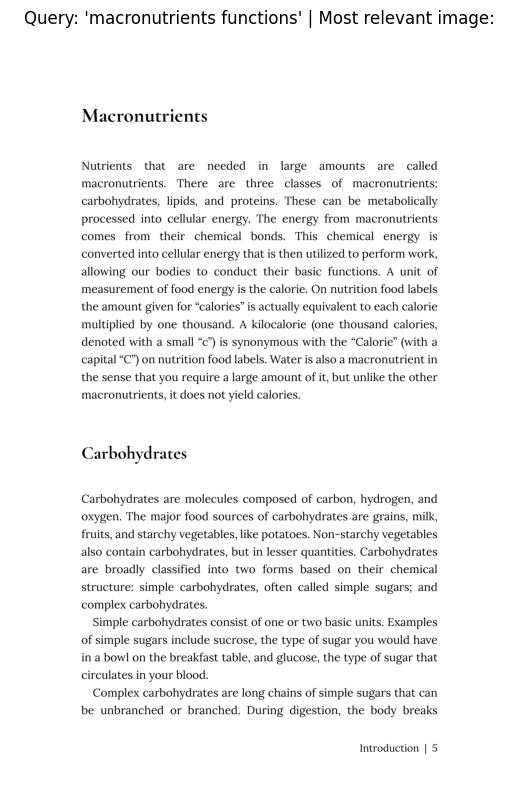

In [73]:
# Heres how we can check our results. Surface the page of text related to our query.
import fitz

pdf_path = "human-nutrition-text.pdf"

doc = fitz.open(pdf_path)
page = doc.load_page(5+41) # Starts at 41+ on this book.

img = page.get_pixmap(dpi=300)

# Save image (optional)
img.save("output_filename.png")
doc.close()

img_array = np.frombuffer(img.samples_mv,
                          dtype=np.uint8).reshape((img.h, img.w, img.n))

img_array

import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant image:")
plt.axis("off")
plt.show()

### Exploring the measure between dot product and cosine similarity

Two of the most common similarity measures between vetors are dot product and cosine similarity.

In essence, closer vectors will have higher scores, further away vectors will have lower scores.

Vectors have direction and magnitude. So which way its going, and how long its going. 

In [76]:
# Cosine similarity function
import torch

def dot_product(vector1, vector2):
    return torch.dot(vector1, vector2)

def cosine_similarity(vector1, vector2):
    dot_product = torch.dot(vector1, vector2)

    # Get the Euclidean/L2 norm.
    norm_vector1 = torch.sqrt(torch.sum(vector1**2))
    norm_vector2 = torch.sqrt(torch.sum(vector2**2))

    return dot_product / (norm_vector1 * norm_vector2)

# Example vector/tensors

vector1 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector2 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector3 = torch.tensor([4, 5, 6], dtype=torch.float32)
vector4 = torch.tensor([-1, -2, -3], dtype=torch.float32)

# Get dot product.
print("Dot product between vector1 and vector2:", dot_product(vector1, vector2))
print("Dot product between vector1 and vector3:", dot_product(vector1, vector3))
print("Dot product between vector1 and vector4:", dot_product(vector1, vector4))

# VIA DOT PRODUCT, Vector that are aligned in direction and magnitude will have a higher positive value!
# So for example, dot product between 1 and 2, since they are the same, they have a high positive value.
# For vector1 and 3, they are aligned in direction (All positive), but vector3s magnitude is higher, so higher value. 
# And for example, vector1 and vector4 are identical, but vector4 has an inversed direction. So same value as 1 and 2, but negative.
# However we dont want this. Theoretically, for example with text, we want vector1 and vector2 to have the highest values, since they match.
# This is done by normalizing and getting cosine similrity.

print("Cosine similarity between vector1 and vector2:", cosine_similarity(vector1, vector2))
print("Cosine similarity between vector1 and vector3:", cosine_similarity(vector1, vector3))
print("Cosine similarity between vector1 and vector4:", cosine_similarity(vector1, vector4))

# Perfect! As normalized, when comparing vector1 and vector2, which are identical, we get 1.0! Which is exactly what we want when they are identical.
# Then with vector1 and vector3, we still get a high value.
# Negative 1 for an exact magnitude match with an opposite direction

# VERY IMPORTANT:

# THE REASON WE CAN USE DOT PRODUCT IN THE WAY ABOVE CODE AS OPPOSED TO HAVING TO USE COSINE SIMILARITY IS BECAUSE OUR DATA IS ALREADY
# NORMALIZED WHEN ENCODED VIA OUR ENCODING ALGORITHM.
# NOrmally, you always want to use Cosine Similarity. But since its all already normalized, no diference between cosine similarity
# and dot product. So if we used cosine similarity, it's just pointless extra compute.


Dot product between vector1 and vector2: tensor(14.)
Dot product between vector1 and vector3: tensor(32.)
Dot product between vector1 and vector4: tensor(-14.)
Cosine similarity between vector1 and vector2: tensor(1.0000)
Cosine similarity between vector1 and vector3: tensor(0.9746)
Cosine similarity between vector1 and vector4: tensor(-1.0000)


### Functionizing our semantic search pipeline

Putting all semantic search into a function or two.

In [87]:
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5,
                                print_time: bool=True):
    """
    Embeds a query with model and returns top K scores and indices from embeddings.
    """

    # Embed the query
    query_embedding = model.encode(query, convert_to_tensor=True)

    # Get dot product scores on embeddings
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on ({len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

    scores, indices = torch.topk(input=dot_scores,
                                 k=n_resources_to_return)
    return scores, indices


def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    """
    Find relevant passages given a query and prints them out along with their scores.
    """

    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return
                                                 )
    for score, indx in zip(scores, indices):
        print(f"Score: {score:.4f}")
        print("Text:")
        print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
        print(f"Page Number: {pages_and_chunks[idx]['page_number']}")
        print("\n")
        
    

In [88]:
query="foods high in fiber"
retrieve_relevant_resources(query=query, embeddings=embeddings)
print_top_results_and_scores(query=query, embeddings=embeddings)

[INFO] Time taken to get scores on (1684 embeddings: 0.00007 seconds.
[INFO] Time taken to get scores on (1684 embeddings: 0.00006 seconds.
Score: 0.6964
Text:
Figure 1.1 The  Macronutrie nts:  Carbohydrat es, Lipids,  Protein, and  Water
Proteins  Proteins are macromolecules composed of chains of subunits called
amino acids.Amino acids are simple subunits composed of carbon,  oxygen,
hydrogen, and nitrogen.Food sources of proteins include  meats, dairy products,
seafood, and a variety of different plant- based foods, most notably soy.The
word protein comes from a  Greek word meaning “of primary importance,” which is
an apt  description of these macronutrients; they are also known  colloquially
as the “workhorses” of life.Proteins provide four  kilocalories of energy per
gram; however providing energy is not  protein’s most important
function.Proteins provide structure to  bones, muscles and skin, and play a role
in conducting most of the  chemical reactions that take place in the
body